In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
import pandas as pd
import numpy as np
import xgboost as xgb
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error,mean_absolute_error
import matplotlib.pyplot as plt
from statsmodels.tsa.api import ExponentialSmoothing,SimpleExpSmoothing,Holt
from matplotlib import pyplot
from statsmodels.tsa.holtwinters import Holt
from statsmodels.tsa.seasonal import seasonal_decompose
from dateutil.parser import parse
from statsmodels.tsa.stattools import adfuller
from sklearn.preprocessing import LabelEncoder
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM,Dense,Dropout


In [3]:
# train_data=pd.read_csv('/content/drive/MyDrive/ACV/ACV - Project/Project 3-Retail-Datasets-train_data/train_data.csv',index_col=2)
# test_data=pd.read_csv('/content/drive/MyDrive/ACV/ACV - Project/Project 3-Retail-Datasets-train_data/test_data.csv',index_col=2)

In [4]:
train_data = pd.read_csv('/content/drive/MyDrive/ACV/ACV - Project/Project 3-Retail-Datasets-train_data/train_data.csv')
test_data = pd.read_csv('/content/drive/MyDrive/ACV/ACV - Project/Project 3-Retail-Datasets-train_data/test_data.csv')

train_data['Date'] = pd.to_datetime(train_data['Date'])
test_data['Date'] = pd.to_datetime(test_data['Date'])

train_data.set_index('Date', inplace=True)
test_data.set_index('Date', inplace=True)

<ipython-input-4-25e1dbaa03c9>:1: DtypeWarning: Columns (7) have mixed types. Specify dtype option on import or set low_memory=False.
  train_data = pd.read_csv('/content/drive/MyDrive/ACV/ACV - Project/Project 3-Retail-Datasets-train_data/train_data.csv')
<ipython-input-4-25e1dbaa03c9>:5: UserWarning: Parsing dates in DD/MM/YYYY format when dayfirst=False (the default) was specified. This may lead to inconsistently parsed dates! Specify a format to ensure consistent parsing.
  test_data['Date'] = pd.to_datetime(test_data['Date'])


In [5]:
train_data = train_data.sort_values(by='Date', ascending=True)
test_data = test_data.sort_values(by='Date', ascending=True)

In [6]:
train_data.columns
#test_data.columns

Index(['Store', 'DayOfWeek', 'Sales', 'Customers', 'Open', 'Promo',
       'StateHoliday', 'SchoolHoliday'],
      dtype='object')

In [7]:
train_data_summed = pd.DataFrame(train_data.groupby('Date')['Sales'].sum())
test_data_summed = test_data.groupby('Date')
test_data_summed.head()

,Store,DayOfWeek,Customers,Open,Promo,StateHoliday,SchoolHoliday
Date,,,,,,,
2015-01-07,1115,3,447,1,1,0,0
2015-01-07,379,3,602,1,1,0,0
2015-01-07,378,3,1178,1,1,0,1
2015-01-07,377,3,1149,1,1,0,0
2015-01-07,376,3,1054,1,1,0,0
...,...,...,...,...,...,...,...
2015-12-07,369,7,0,0,0,0,0
2015-12-07,370,7,0,0,0,0,0
2015-12-07,371,7,0,0,0,0,0


In [8]:
train_data_summed.head()

,Sales
Date,
2013-01-01,97235
2013-01-02,6949829
2013-01-03,6347820
2013-01-04,6638954
2013-01-05,5951593


<Axes: xlabel='Date'>

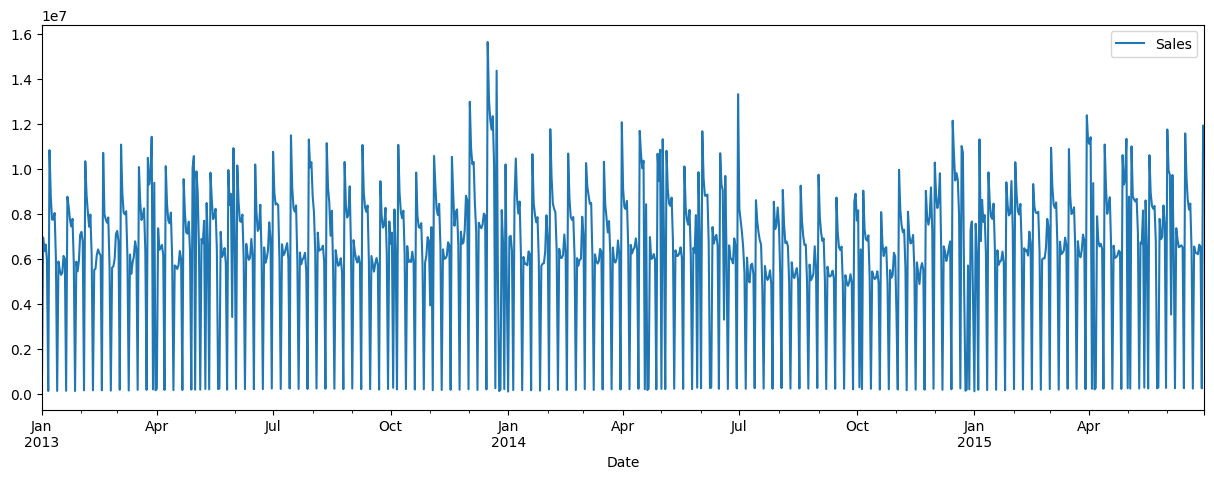

In [9]:

train_data_summed.plot(figsize=(15,5))


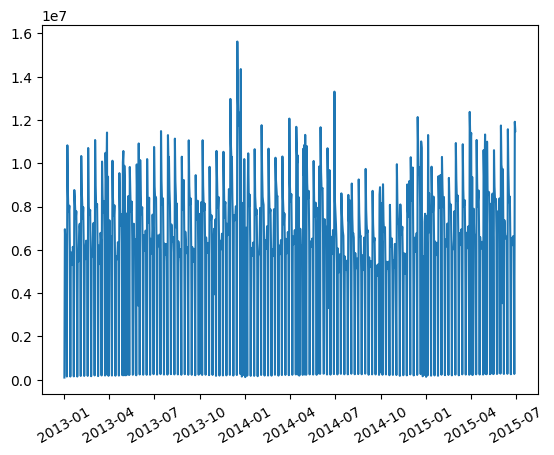

In [10]:
#plot time series
plt.plot(train_data_summed)
plt.xticks(rotation=30)
plt.show()

In [11]:
# #rolling average transform
# rollingseries_50=train_timeseries[1:10000].rolling(window=50,min_periods=1)
# rollingseries_500=train_timeseries[1:10000].rolling(window=500,min_periods=1)
# rollingseries_5000=train_timeseries[1:10000].rolling(window=5000,min_periods=1)
# rollingmean=rollingseries_50.mean()
# rollingmean.head()

In [12]:
#rolling average transform
rollingseries_50=train_data_summed.rolling(window=50,min_periods=1)
rollingseries_500=train_data_summed.rolling(window=500,min_periods=1)
rollingseries_5000=train_data_summed.rolling(window=5000,min_periods=1)
rollingmean=rollingseries_50.mean()
rollingmean.head()

,Sales
Date,
2013-01-01,9.723500e+04
2013-01-02,3.523532e+06
2013-01-03,4.464961e+06
2013-01-04,5.008460e+06
2013-01-05,5.197086e+06


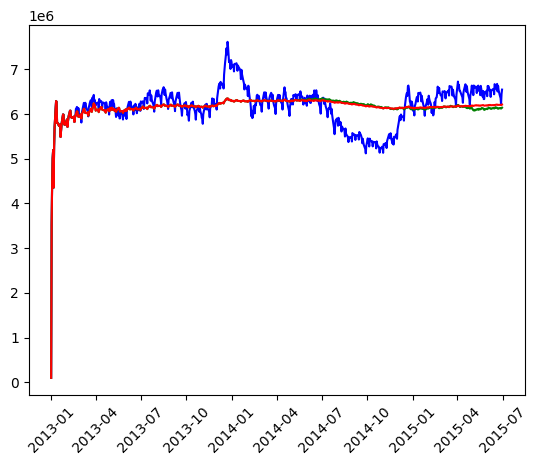

In [13]:
plt.plot(rollingmean,color = 'blue')
plt.plot(rollingseries_500.mean(), color = 'green')
plt.plot(rollingseries_5000.mean(),color = 'red')
plt.xticks(rotation=45)
pyplot.show()

<Axes: xlabel='Date'>

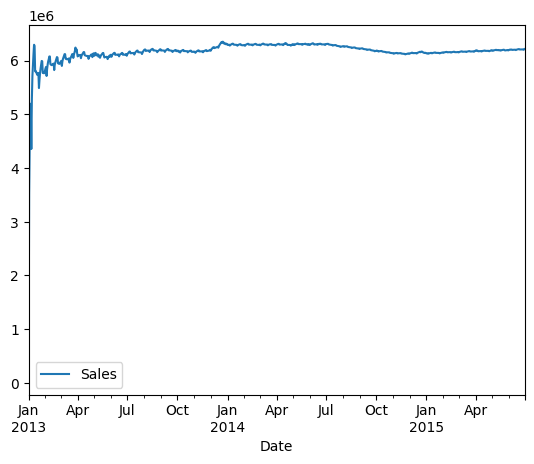

In [14]:
train_data_summed.expanding().mean().plot()

In [15]:
train_data.head()

,Store,DayOfWeek,Sales,Customers,Open,Promo,StateHoliday,SchoolHoliday
Date,,,,,,,,
2013-01-01,1115,2,0,0,0,0,a,1
2013-01-01,379,2,0,0,0,0,a,1
2013-01-01,378,2,0,0,0,0,a,1
2013-01-01,377,2,0,0,0,0,a,1
2013-01-01,376,2,0,0,0,0,a,1


In [16]:
#train_timeseries = train_data['Sales']
data = train_data_summed

# Calculate exponentially weighted moving average (EWMA) with alpha = 0.1
data['ewma'] = data.ewm(alpha=0.1).mean()

(array([15706., 15796., 15887., 15979., 16071., 16161., 16252., 16344.,
        16436., 16526., 16617.]),
 [Text(15706.0, 0, '2013-01'),
  Text(15796.0, 0, '2013-04'),
  Text(15887.0, 0, '2013-07'),
  Text(15979.0, 0, '2013-10'),
  Text(16071.0, 0, '2014-01'),
  Text(16161.0, 0, '2014-04'),
  Text(16252.0, 0, '2014-07'),
  Text(16344.0, 0, '2014-10'),
  Text(16436.0, 0, '2015-01'),
  Text(16526.0, 0, '2015-04'),
  Text(16617.0, 0, '2015-07')])

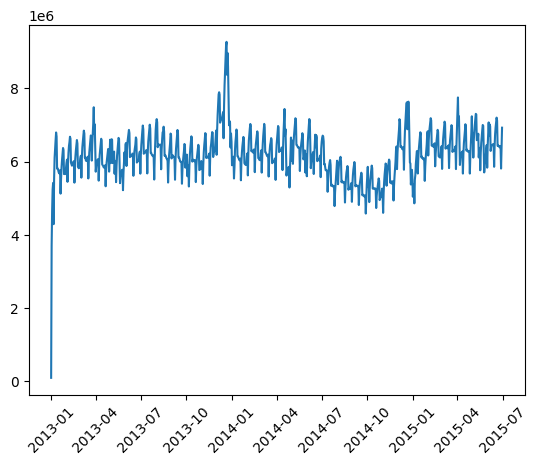

In [17]:
plt.plot(data['ewma'])
plt.xticks(rotation=45)

In [18]:
#SimpleExponentialsmoothing
data=train_data_summed['Sales']

fit1=SimpleExpSmoothing(data).fit(smoothing_level=0.2,optimized=False)
fit2=SimpleExpSmoothing(data).fit(smoothing_level=0.8,optimized=False)

/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)


(array([15706., 15796., 15887., 15979., 16071., 16161., 16252., 16344.,
        16436., 16526., 16617.]),
 [Text(15706.0, 0, '2013-01'),
  Text(15796.0, 0, '2013-04'),
  Text(15887.0, 0, '2013-07'),
  Text(15979.0, 0, '2013-10'),
  Text(16071.0, 0, '2014-01'),
  Text(16161.0, 0, '2014-04'),
  Text(16252.0, 0, '2014-07'),
  Text(16344.0, 0, '2014-10'),
  Text(16436.0, 0, '2015-01'),
  Text(16526.0, 0, '2015-04'),
  Text(16617.0, 0, '2015-07')])

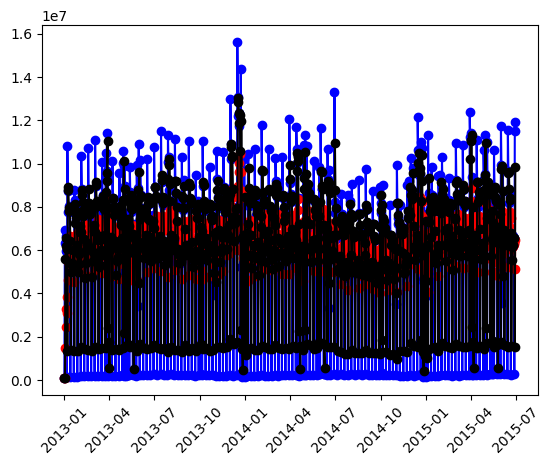

In [19]:
plt.plot(data,marker='o',color='blue')
plt.plot(fit1.fittedvalues,marker='o',color='red')
plt.plot(fit2.fittedvalues,marker='o',color='black')
plt.xticks(rotation=45)

In [20]:
#Holt method
fit1=Holt(data).fit()
#fit2=Holt(data,exponential=True).fit()



/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/holtwinters/model.py:917: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  warnings.warn(


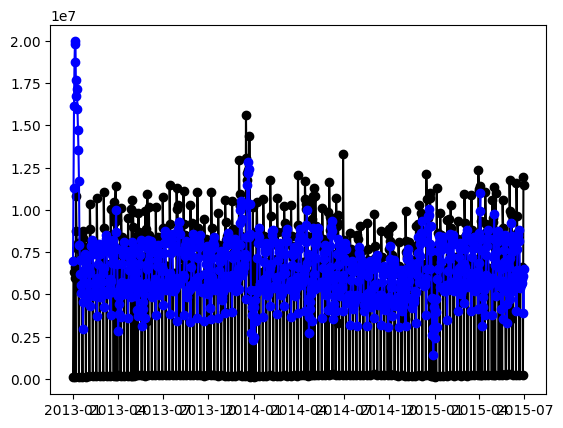

In [21]:
plt.plot(data,marker='o',color='black')
plt.plot(fit1.fittedvalues,marker='o',color='blue')
#plt.plot(fit2.fittedvalues,marker='o',color='red')

In [22]:
#train_timeseries.head()
data1=train_data_summed

In [23]:
data1.columns

Index(['Sales', 'ewma'], dtype='object')

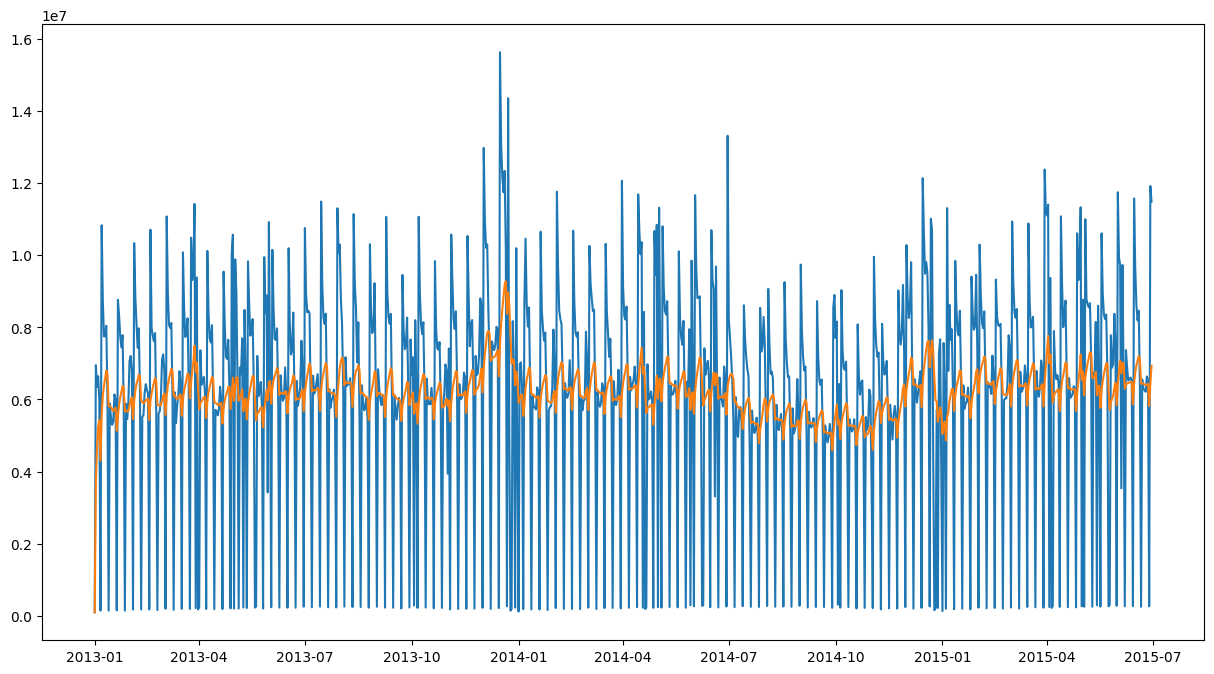

In [24]:
from matplotlib import rcParams
plt.figure(figsize=(15,8))
plt.plot(data1)

In [25]:
#multiplicative decomposition

#mul_result=seasonal_decompose(data1['Sales'],model='multiplicative',period=1)

#additive decomposition

add_result=seasonal_decompose(data1['Sales'],model='additive',period=1)

Text(0.5, 0.98, '\n Addition Decompose')

<Figure size 5000x5000 with 0 Axes>

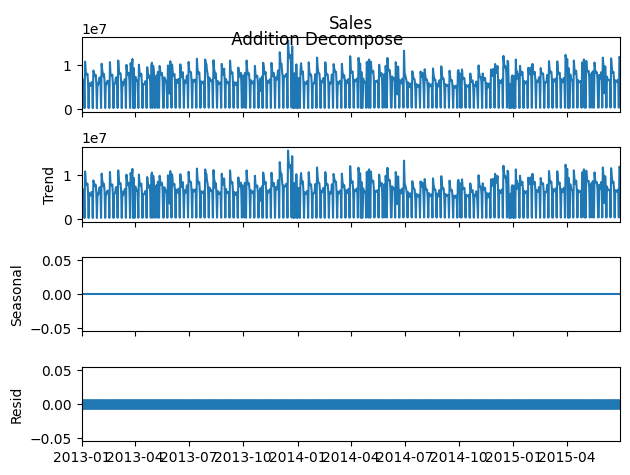

In [26]:
plt.figure(figsize=(50,50))
#mul_result.plot().suptitle('\n Multiplication Decompose',fontsize=12)
add_result.plot().suptitle('\n Addition Decompose',fontsize=12)

In [27]:
def adf_test(series):
    result=adfuller(series)
    print('ADF Statistics: {}'.format(result[0]))
    print('p- value: {}'.format(result[1]))
    if result[1] <= 0.05:
        print("strong evidence against the null hypothesis, reject the null hypothesis. Data has no unit root and is stationary")
    else:
        print("weak evidence against null hypothesis, time series has a unit root, indicating it is non-stationary ")

In [28]:
adf_test(data1['Sales'])

ADF Statistics: -4.727724389097971
p- value: 7.461975261981394e-05
strong evidence against the null hypothesis, reject the null hypothesis. Data has no unit root and is stationary


In [29]:
#stationarity check
adfuller_result=adfuller(data1['Sales'].values,autolag='AIC')
print(f'ADfuller statistic : {adfuller_result[0]}')
print(f'ADfuller p value : {adfuller_result[1]}')
print(adfuller_result)

ADfuller statistic : -4.727724389097971
ADfuller p value : 7.461975261981394e-05
(-4.727724389097971, 7.461975261981394e-05, 20, 890, {'1%': -3.43771883253448, '5%': -2.8647929301713977, '10%': -2.568502085595253}, 28228.919772544672)


In [30]:
from statsmodels.tsa.stattools import acf,pacf
from statsmodels.graphics.tsaplots import plot_acf,plot_pacf
ACF_lag=acf(data1['Sales'])


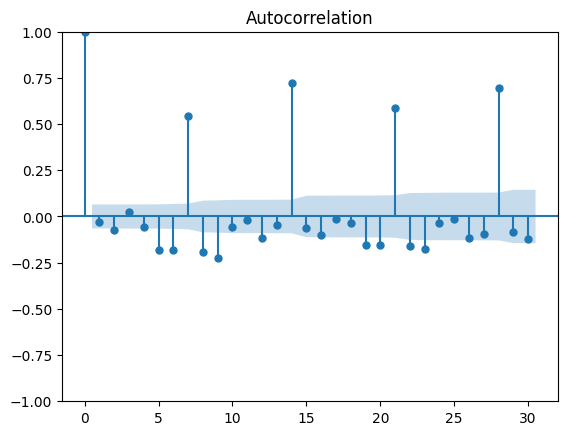

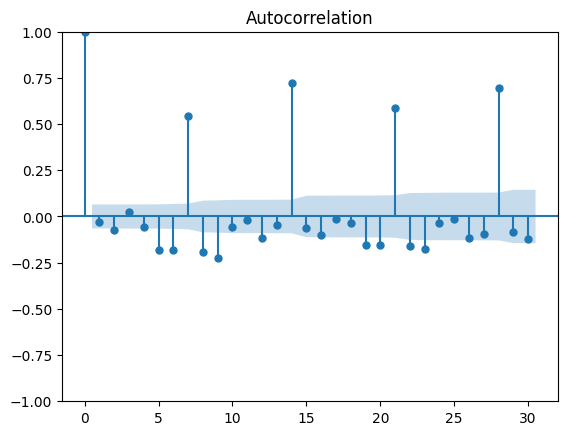

In [31]:
plot_acf(data1['Sales'])

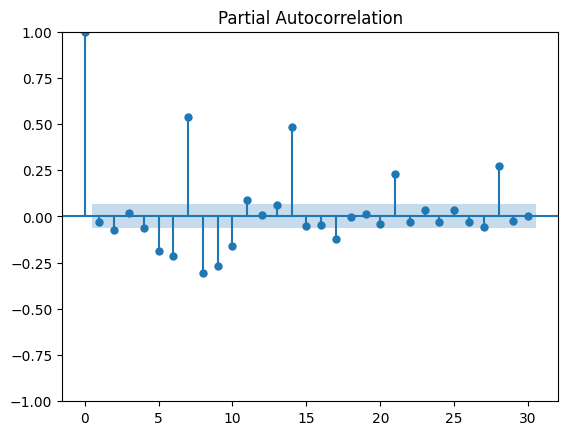

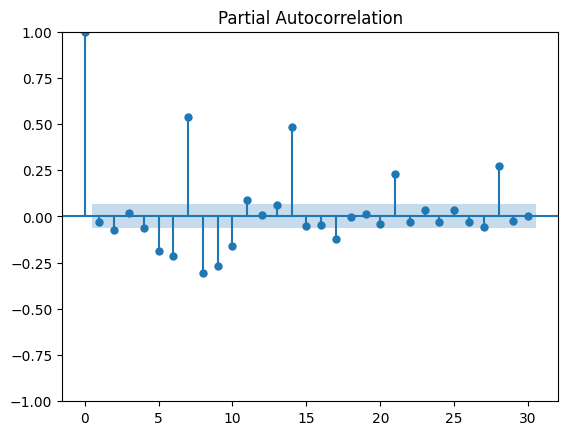

In [32]:
plot_pacf(data1['Sales'])

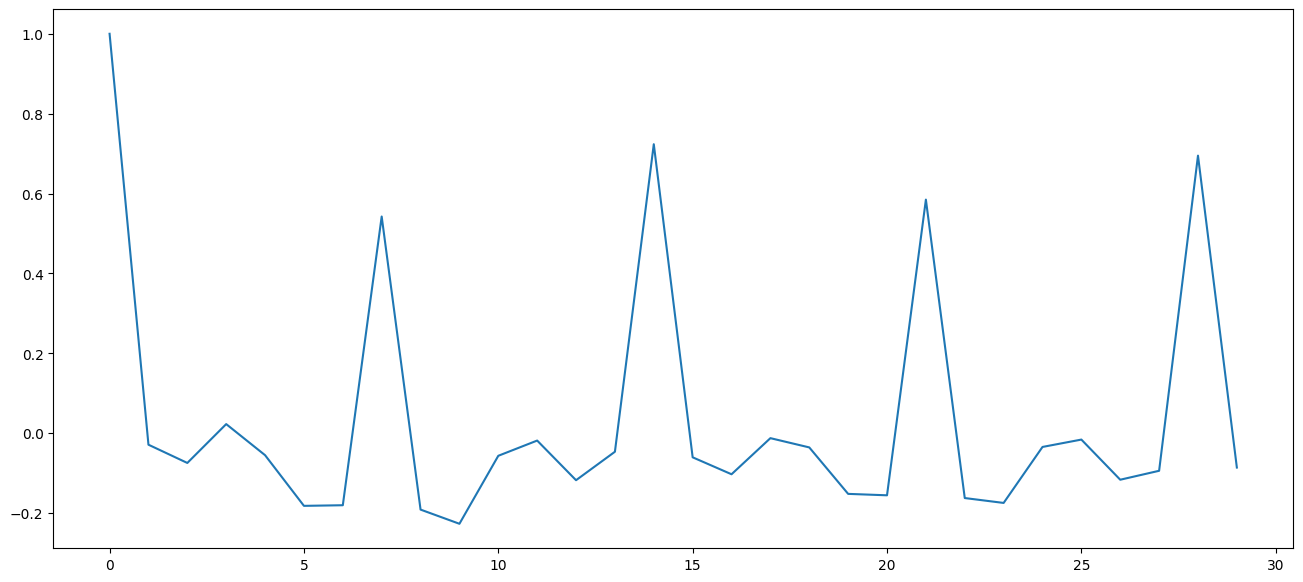

In [33]:
#plot acf
plt.figure(figsize=(16,7))
plt.plot(ACF_lag)

In [34]:
pacf_lag=pacf(data1['Sales'],nlags=30,method='ols')


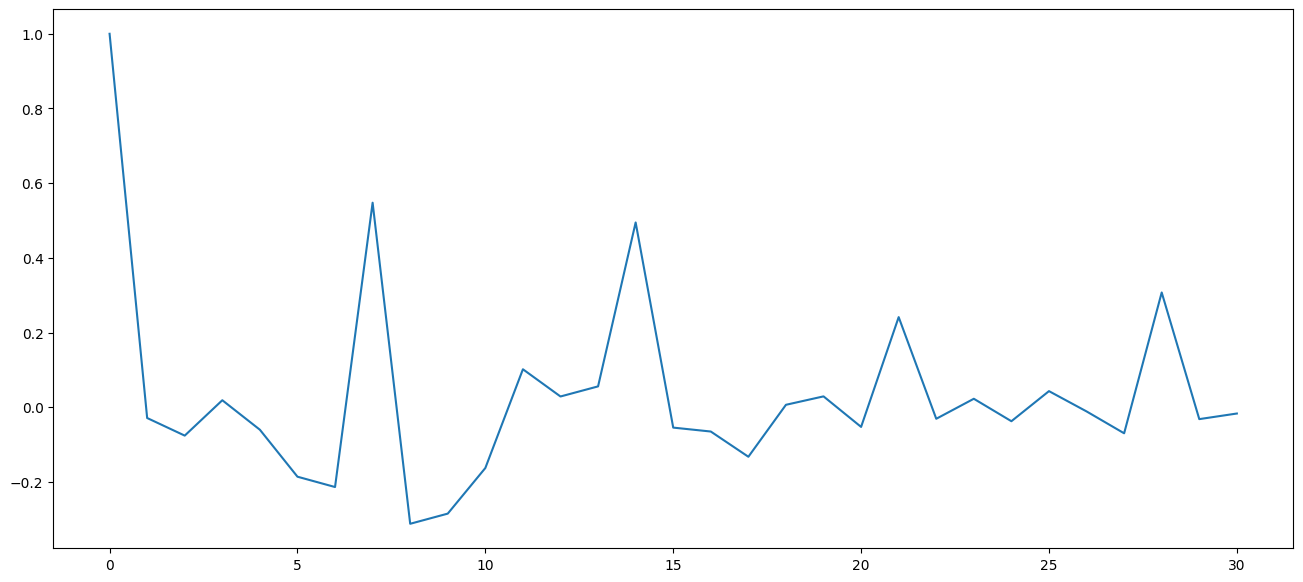

In [35]:
#plot pacf
plt.figure(figsize=(16,7))
plt.plot(pacf_lag)

In [36]:
data1.tail()

,Sales,ewma
Date,,
2015-06-26,6634687,6.418090e+06
2015-06-27,6538314,6.430113e+06
2015-06-28,262669,5.813368e+06
2015-06-29,11916672,6.423699e+06
2015-06-30,11483932,6.929722e+06


In [37]:
from statsmodels.tsa.arima.model import ARIMA
data2=data1

In [38]:
arimamodel=ARIMA(data2['Sales'],order=(7,0,0))
arima_model_fit=arimamodel.fit()
y_pred=arima_model_fit.predict(len(data2),len(data2)+19,typ='levels')
y_pred_curr = arima_model_fit.predict(892,911,typ='levels')
#print(y_pred)

/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/representation.py:374: FutureWarning: Unknown keyword arguments: dict_keys(['typ']).Passing unknown keyword arguments will raise a TypeError beginning in version 0.15.
  warnings.warn(msg, FutureWarning)


In [39]:
arimamodel.fit().summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:                  Sales   No. Observations:                  911
Model:                 ARIMA(7, 0, 0)   Log Likelihood              -14716.628
Date:                Sun, 25 Feb 2024   AIC                          29451.256
Time:                        19:33:49   BIC                          29494.587
Sample:                    01-01-2013   HQIC                         29467.799
                         - 06-30-2015                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const       6.214e+06    1.2e+05     51.706      0.000    5.98e+06    6.45e+06
ar.L1          0.0351      0.019      1.803      0.071      -0.003       0.073
ar.L2          0.0192      0.027      0.714      0.475      -0.034       0.072
ar.L3          0.0480      0.028      1.737      0.082      -0.006       0.102
ar.L4         -0.0828      0.027     -3.090      0.002      -0.135      -0.030
ar.L5         -0.1465      0.033     -4.447      0.000      -0.211      -0.082
ar.L6         -0.1723      0.036     -4.777      0.000      -0.243      -0.102
ar.L7          0.5496      0.023     23.560      0.000       0.504       0.595
sigma2      6.252e+12      0.006   1.13e+15      0.000    6.25e+12    6.25e+12
===================================================================================
Ljung-Box (L1) (Q):                  27.22   Jarque-Bera (JB):                76.55
Prob(Q):                              0.00   Prob(JB):                         0.00
Heteroskedasticity (H):               1.16   Skew:                             0.27
Prob(H) (two-sided):                  0.20   Kurtosis:                         4.32
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
[2] Covariance matrix is singular or near-singular, with condition number 6.06e+39. Standard errors may be unstable.
"""

In [40]:
y_act=data1[891:911]['Sales']
len(y_act)

20

In [41]:
len(y_pred_curr)

20

In [42]:
residual = y_act - y_pred_curr

<ipython-input-43-b46a10f78935>:4: UserWarning: Legend does not support handles for str instances.
A proxy artist may be used instead.
See: https://matplotlib.org/stable/tutorials/intermediate/legend_guide.html#controlling-the-legend-entries
  plt.legend("Data","Predictions")


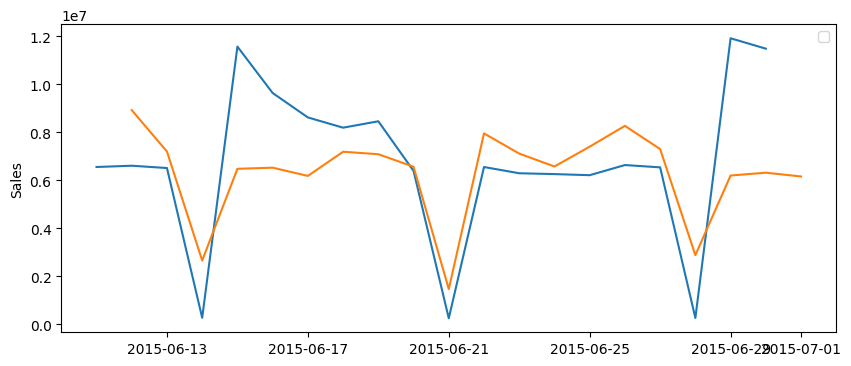

In [43]:
plt.figure(figsize=(10,4))
plt.plot(y_act)
plt.plot(y_pred_curr)
plt.legend("Data","Predictions")
plt.ylabel("Sales")
plt.show()

<ipython-input-44-e1a5ce0f43e0>:4: UserWarning: Legend does not support handles for str instances.
A proxy artist may be used instead.
See: https://matplotlib.org/stable/tutorials/intermediate/legend_guide.html#controlling-the-legend-entries
  plt.legend("Data","Predictions")


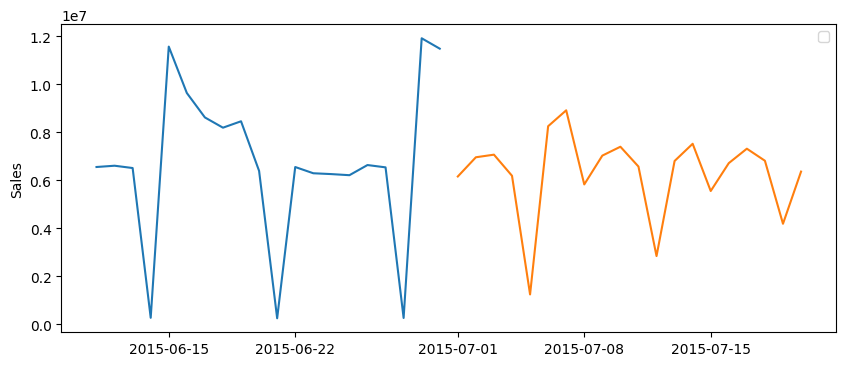

In [44]:
plt.figure(figsize=(10,4))
plt.plot(y_act)
plt.plot(y_pred)
plt.legend("Data","Predictions")
plt.ylabel("Sales")
plt.show()

In [45]:
mamodel=ARIMA(data2['Sales'],order=(0,0,7))
ma_model_fit=mamodel.fit()
y_pred=ma_model_fit.predict(len(data2),len(data2)+19,typ='levels')
y_pred_curr_ma = ma_model_fit.predict(892,911,typ='levels')
#print(y_pred)

/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/representation.py:374: FutureWarning: Unknown keyword arguments: dict_keys(['typ']).Passing unknown keyword arguments will raise a TypeError beginning in version 0.15.
  warnings.warn(msg, FutureWarning)


In [46]:
y_act_ma=data1[891:911]['Sales']
len(y_act_ma)
residual = y_act_ma - y_pred_curr_ma

In [47]:
mamodel.fit().summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:                  Sales   No. Observations:                  911
Model:                 ARIMA(0, 0, 7)   Log Likelihood              -14805.600
Date:                Sun, 25 Feb 2024   AIC                          29629.199
Time:                        19:33:52   BIC                          29672.530
Sample:                    01-01-2013   HQIC                         29645.742
                         - 06-30-2015                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const       6.214e+06   9.38e+04     66.228      0.000    6.03e+06     6.4e+06
ma.L1          0.0298      0.033      0.909      0.363      -0.034       0.094
ma.L2          0.0144      0.039      0.366      0.714      -0.063       0.091
ma.L3          0.0151      0.036      0.419      0.675      -0.055       0.086
ma.L4         -0.1022      0.037     -2.741      0.006      -0.175      -0.029
ma.L5         -0.1803      0.043     -4.198      0.000      -0.265      -0.096
ma.L6         -0.2835      0.045     -6.290      0.000      -0.372      -0.195
ma.L7          0.2835      0.041      6.933      0.000       0.203       0.364
sigma2        9.6e+12      0.003   3.24e+15      0.000     9.6e+12     9.6e+12
===================================================================================
Ljung-Box (L1) (Q):                   0.06   Jarque-Bera (JB):                11.46
Prob(Q):                              0.80   Prob(JB):                         0.00
Heteroskedasticity (H):               1.20   Skew:                            -0.17
Prob(H) (two-sided):                  0.11   Kurtosis:                         3.43
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
[2] Covariance matrix is singular or near-singular, with condition number 5.2e+30. Standard errors may be unstable.
"""

<ipython-input-48-b46a10f78935>:4: UserWarning: Legend does not support handles for str instances.
A proxy artist may be used instead.
See: https://matplotlib.org/stable/tutorials/intermediate/legend_guide.html#controlling-the-legend-entries
  plt.legend("Data","Predictions")


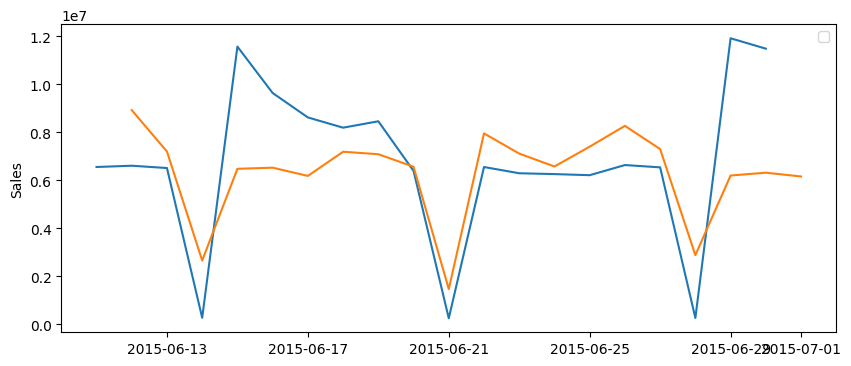

In [48]:
plt.figure(figsize=(10,4))
plt.plot(y_act)
plt.plot(y_pred_curr)
plt.legend("Data","Predictions")
plt.ylabel("Sales")
plt.show()

In [49]:
from sklearn.metrics import mean_squared_error
mse_ma=mean_squared_error(y_act_ma,y_pred_curr_ma)
rmse=np.sqrt(mse_ma)
rmse = (rmse/(y_act_ma.max() - y_act_ma.min()))*100
rmse

29.147690660744175

In [50]:
import statsmodels.api as sm

In [51]:
from sklearn.metrics import mean_squared_error
mse=mean_squared_error(y_act,y_pred_curr)
rmse=np.sqrt(mse)
rmse = (rmse/(y_act.max() - y_act.min()))*100
rmse

33.30128062333658

In [52]:
arimamodel=ARIMA(data2['Sales'],order=(7,0,7))
arma_model_fit=arimamodel.fit()
y_pred_arma=arma_model_fit.predict(len(data2),len(data2)+19,typ='levels')
y_pred_curr_arma = arma_model_fit.predict(892,911,typ='levels')

/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/representation.py:374: FutureWarning: Unknown keyword arguments: dict_keys(['typ']).Passing unknown keywo

In [53]:
arimamodel.fit().summary()

/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:                  Sales   No. Observations:                  911
Model:                 ARIMA(7, 0, 7)   Log Likelihood              -14494.366
Date:                Sun, 25 Feb 2024   AIC                          29020.733
Time:                        19:34:10   BIC                          29097.765
Sample:                    01-01-2013   HQIC                         29050.143
                         - 06-30-2015                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const       6.214e+06   1.83e-09    3.4e+15      0.000    6.21e+06    6.21e+06
ar.L1         -0.0580      0.039     -1.470      0.142      -0.135       0.019
ar.L2         -0.0603      0.040     -1.521      0.128      -0.138       0.017
ar.L3         -0.0593      0.040     -1.478      0.139      -0.138       0.019
ar.L4         -0.0567      0.041     -1.388      0.165      -0.137       0.023
ar.L5         -0.0600      0.040     -1.493      0.135      -0.139       0.019
ar.L6         -0.0582      0.040     -1.445      0.148      -0.137       0.021
ar.L7          0.9368      0.040     23.658      0.000       0.859       1.014
ma.L1          0.1502      0.051      2.936      0.003       0.050       0.250
ma.L2          0.1341      0.057      2.368      0.018       0.023       0.245
ma.L3          0.1747      0.062      2.839      0.005       0.054       0.295
ma.L4          0.1078      0.062      1.726      0.084      -0.015       0.230
ma.L5          0.1234      0.057      2.164      0.030       0.012       0.235
ma.L6          0.1116      0.058      1.917      0.055      -0.003       0.226
ma.L7         -0.8338      0.055    -15.105      0.000      -0.942      -0.726
sigma2       5.07e+12   9.38e-15    5.4e+26      0.000    5.07e+12    5.07e+12
===================================================================================
Ljung-Box (L1) (Q):                  24.69   Jarque-Bera (JB):              1054.08
Prob(Q):                              0.00   Prob(JB):                         0.00
Heteroskedasticity (H):               1.22   Skew:                            -1.16
Prob(H) (two-sided):                  0.08   Kurtosis:                         7.74
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
[2] Covariance matrix is singular or near-singular, with condition number 3.52e+42. Standard errors may be unstable.
"""

<ipython-input-54-1e18aeac6e2e>:4: UserWarning: Legend does not support handles for str instances.
A proxy artist may be used instead.
See: https://matplotlib.org/stable/tutorials/intermediate/legend_guide.html#controlling-the-legend-entries
  plt.legend("Data","Predictions")


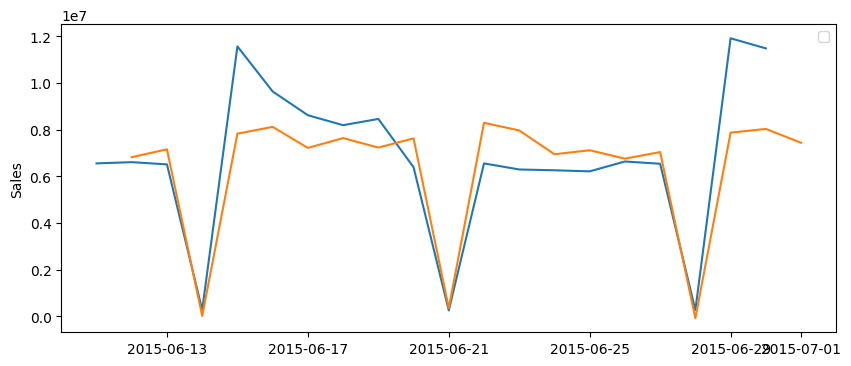

In [54]:
plt.figure(figsize=(10,4))
plt.plot(y_act)
plt.plot(y_pred_curr_arma)
plt.legend("Data","Predictions")
plt.ylabel("Sales")
plt.show()

<ipython-input-55-881bc1c29f7e>:4: UserWarning: Legend does not support handles for str instances.
A proxy artist may be used instead.
See: https://matplotlib.org/stable/tutorials/intermediate/legend_guide.html#controlling-the-legend-entries
  plt.legend("Data","Predictions")


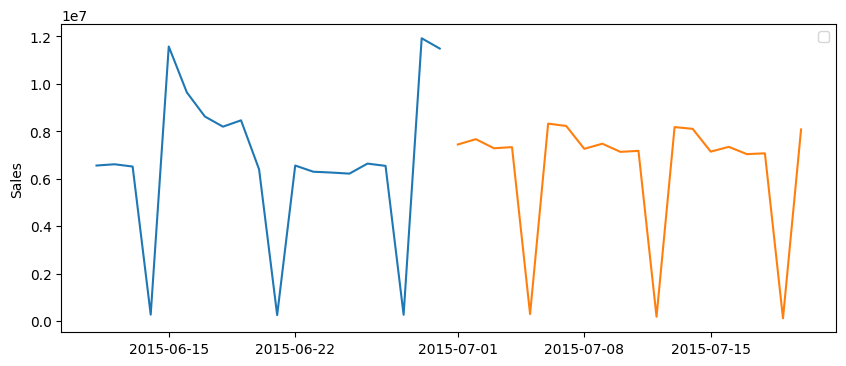

In [55]:
plt.figure(figsize=(10,4))
plt.plot(y_act)
plt.plot(y_pred_arma)
plt.legend("Data","Predictions")
plt.ylabel("Sales")
plt.show()

In [56]:
y_pred_test_arma=arma_model_fit.predict(0,len(data2),typ='levels')
len(list(y_pred_test_arma))


/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/representation.py:374: FutureWarning: Unknown keyword arguments: dict_keys(['typ']).Passing unknown keyword arguments will raise a TypeError beginning in version 0.15.
  warnings.warn(msg, FutureWarning)


912

<ipython-input-57-fde3ab70b6a5>:4: UserWarning: Legend does not support handles for str instances.
A proxy artist may be used instead.
See: https://matplotlib.org/stable/tutorials/intermediate/legend_guide.html#controlling-the-legend-entries
  plt.legend("Data","Predictions")


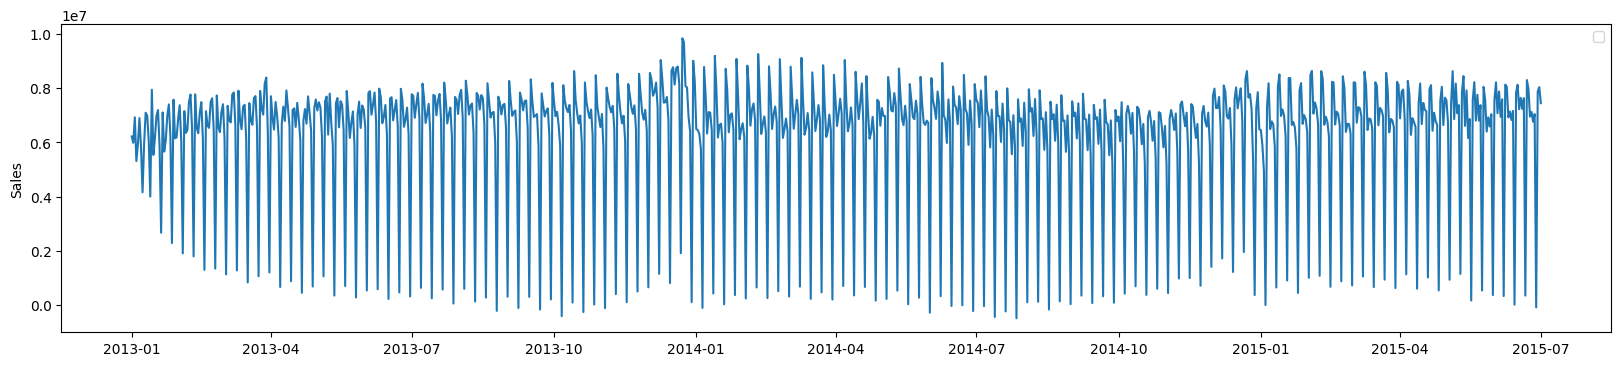

In [57]:
plt.figure(figsize=(20,4))
#plt.plot(y_act)
plt.plot(y_pred_test_arma)
plt.legend("Data","Predictions")
plt.ylabel("Sales")
plt.show()

In [58]:
model=sm.tsa.statespace.SARIMAX(data1['Sales'],order=(1, 1, 1),seasonal_order=(1,0,1,12))
results=model.fit()

/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)


In [59]:
data1.columns

Index(['Sales', 'ewma'], dtype='object')

<Axes: xlabel='Date'>

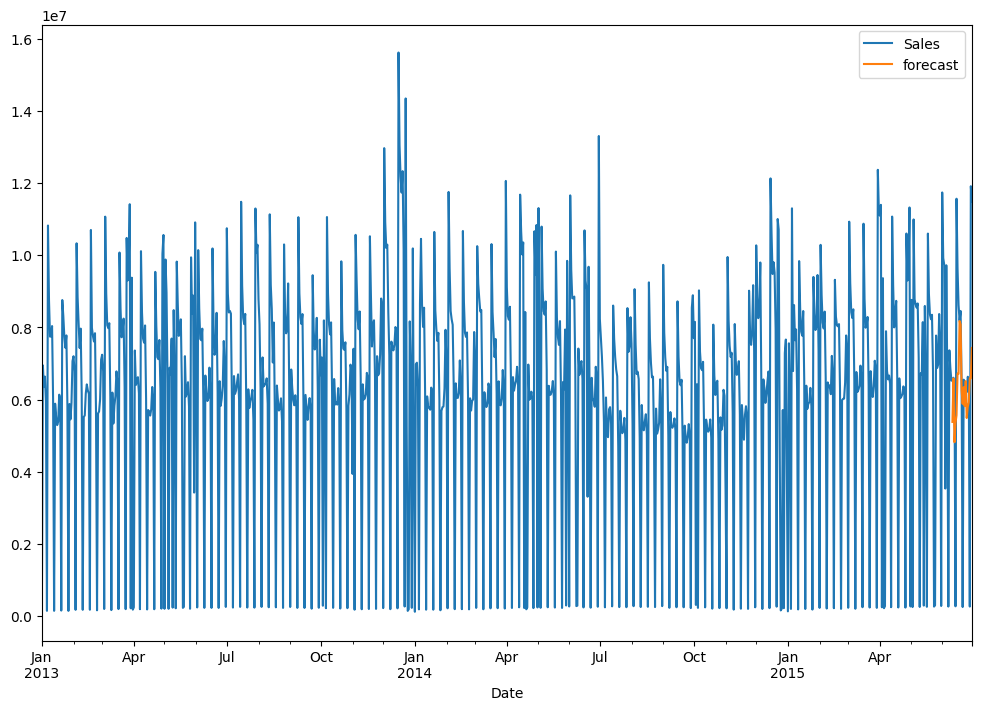

In [60]:
data1['forecast']=results.predict(start=891,end=910,dynamic=True)
data1[['Sales','forecast']].plot(figsize=(12,8))

In [61]:
from pandas.tseries.offsets import DateOffset
future_dates=[data1.index[-1]+ DateOffset(months=x)for x in range(0,12)]
future_datest_df=pd.DataFrame(index=future_dates[1:],columns=data1.columns)

In [62]:
future_df=pd.concat([data1,future_datest_df])
future_df['forecast'] = results.predict(start = 912, end = 924, dynamic= True)
future_df.shape

/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/kalman_filter.py:2473: ValueWarning: Dynamic prediction specified to begin during out-of-sample forecasting period, and so has no effect.
  warn('Dynamic prediction specified to begin during'


(922, 3)

/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/kalman_filter.py:2473: ValueWarning: Dynamic prediction specified to begin during out-of-sample forecasting period, and so has no effect.
  warn('Dynamic prediction specified to begin during'


<Axes: >

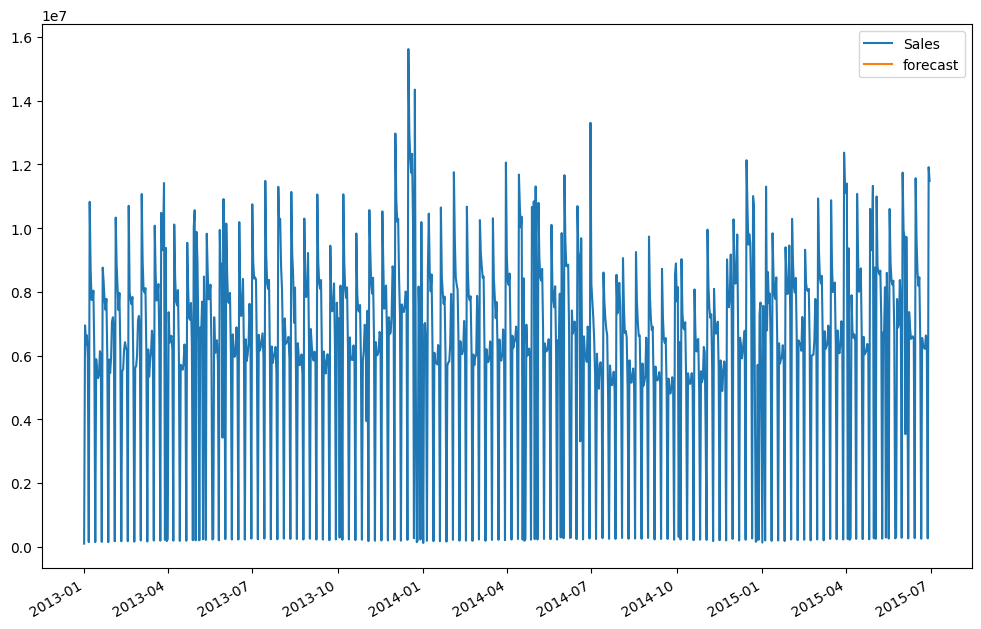

In [63]:
future_df['forecast'] = results.predict(start = 912, end = 924, dynamic= True)
future_df[['Sales', 'forecast']].plot(figsize=(12, 8))

In [64]:
# import itertools
# i=j=range(0,4)
# ij=itertools.product(i,j)
# for parameters in ij:
#   try:
#     mod=ARMA(data2['Sales'],order=parameters)
#     result=mod.fit()
#     print("ARIMA{} AND AIC{}".format(parameters,result.aic))
#   except:
#     continue

In [65]:
train_data.reset_index()
#test_data.dtypes

,Date,Store,DayOfWeek,Sales,Customers,Open,Promo,StateHoliday,SchoolHoliday
0,2013-01-01,1115,2,0,0,0,0,a,1
1,2013-01-01,379,2,0,0,0,0,a,1
2,2013-01-01,378,2,0,0,0,0,a,1
3,2013-01-01,377,2,0,0,0,0,a,1
4,2013-01-01,376,2,0,0,0,0,a,1
...,...,...,...,...,...,...,...,...,...
982639,2015-06-30,746,2,8082,598,1,1,0,0
982640,2015-06-30,747,2,10850,770,1,1,0,0
982641,2015-06-30,748,2,9862,654,1,1,0,1
982642,2015-06-30,742,2,11505,996,1,1,0,1


In [66]:
train_data['StateHoliday']=train_data['StateHoliday'].astype(str)

In [67]:
#Labelencoding
lenc=LabelEncoder()
lenc_train=lenc.fit_transform(train_data['StateHoliday'])
lenc_train=pd.DataFrame(lenc_train)
lenc_train.head()


,0
0,1
1,1
2,1
3,1
4,1


In [68]:
train_data_enc=train_data.drop(columns='StateHoliday')
train_data_enc.reset_index(inplace=True, drop=True)
#train_data_enc.reset_index()
#lenc_train.columns

In [69]:
train_data_1=pd.concat([train_data_enc,lenc_train],axis=1,)
#train_data_1.set_index(train_data_enc['Date'], inplace=True)
train_data_1.dtypes
train_data_1.shape


(982644, 8)

In [70]:

train_data_1.shape
test_data.columns

Index(['Store', 'DayOfWeek', 'Customers', 'Open', 'Promo', 'StateHoliday',
       'SchoolHoliday'],
      dtype='object')

In [71]:
train_data_1.rename(columns={'0':'StateHoliday'},inplace=True)
type(train_data_1.columns)
train_data_1.columns = train_data_1.columns.astype(str)

In [72]:
y_train=train_data_1['Sales']
train_data_1=train_data_1.drop(columns=['Sales'])

In [73]:

y_train=pd.DataFrame(y_train)
y_train.shape
train_data_1.columns

Index(['Store', 'DayOfWeek', 'Customers', 'Open', 'Promo', 'SchoolHoliday',
       '0'],
      dtype='object')

In [74]:
test_data.rename(columns={'StateHoliday': '0'}, inplace=True)

In [75]:
from sklearn.preprocessing import MinMaxScaler
scaler=MinMaxScaler()
scaler_x=scaler.fit(train_data_1)
scaled_xtrain=scaler_x.transform(train_data_1)
scaled_xtest = MinMaxScaler().fit_transform(test_data)
scaler_y = scaler.fit(y_train)
scaled_ytrain = scaler_y.transform(y_train)


In [76]:
scaled_xtrain.shape
scaled_ytrain.shape

(982644, 1)

In [77]:
trainX = []
trainY = []
n_future = 1   # Number of days we want to look into the future based on the past days.
n_past = 14 #Number of past days we want to use to predict the future.
for i in range(n_past,len(scaled_xtrain)-n_future+1):
  trainX.append(scaled_xtrain[i-n_past:i,0:scaled_xtrain.shape[1]])
  trainY.append(scaled_ytrain[i+n_future-1:i+n_future])
trainX, trainY = np.array(trainX), np.array(trainY)
print(trainX.shape,trainY.shape)

(982630, 14, 7) (982630, 1, 1)


In [78]:
#for generalisation
testX = []
n_future = 1   # Number of days we want to look into the future based on the past days.
n_past = 14 #Number of past days we want to use to predict the future.
for i in range(n_past,len(scaled_xtest)-n_future+1):
  testX.append(scaled_xtest[i-n_past:i,0:scaled_xtest.shape[1]])
testX = np.array(testX)
print(testX.shape)

(34551, 14, 7)


In [79]:
X_train,X_test,y_train,y_test=train_test_split(trainX,trainY,test_size=0.2,random_state=30)
X_train.shape

(786104, 14, 7)

In [80]:
model = Sequential()
model.add(LSTM(64, activation='relu', input_shape=(X_train.shape[1], X_train.shape[2]), return_sequences=True))
model.add(LSTM(32, activation='relu', return_sequences=False))
model.add(Dropout(0.2))
model.add(Dense(y_train.shape[1]))

model.compile(optimizer='adam', loss='mse')
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, 14, 64)            18432     
                                                                 
 lstm_1 (LSTM)               (None, 32)                12416     
                                                                 
 dropout (Dropout)           (None, 32)                0         
                                                                 
 dense (Dense)               (None, 1)                 33        
                                                                 
Total params: 30881 (120.63 KB)
Trainable params: 30881 (120.63 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


Epoch 1/5
4717/4717 [==============================] - 171s 35ms/step - loss: 0.0043 - val_loss: 0.0040
Epoch 2/5
4717/4717 [==============================] - 166s 35ms/step - loss: 0.0041 - val_loss: 0.0039
Epoch 3/5
4717/4717 [==============================] - 165s 35ms/step - loss: 0.0041 - val_loss: 0.0039
Epoch 4/5
4717/4717 [==============================] - 204s 43ms/step - loss: 0.0041 - val_loss: 0.0039
Epoch 5/5
4717/4717 [==============================] - 169s 36ms/step - loss: 0.0041 - val_loss: 0.0039


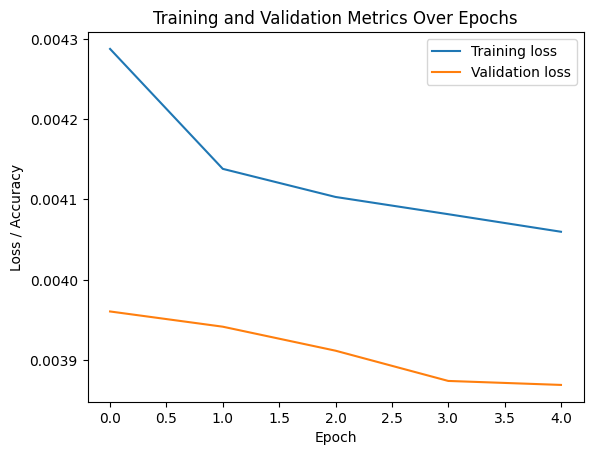

In [81]:
history = model.fit(X_train, y_train, epochs=5, batch_size=150, validation_split=0.1, verbose=1)

plt.plot(history.history['loss'], label='Training loss')

plt.plot(history.history['val_loss'], label='Validation loss')


# Add labels and legend
plt.xlabel('Epoch')
plt.ylabel('Loss / Accuracy')
plt.title('Training and Validation Metrics Over Epochs')
plt.legend()
plt.show()

In [82]:
#Validation prediction
train_predictions = model.predict(X_test)

6142/6142 [==============================] - 32s 5ms/step


In [83]:
#Validation loss
#y_pred=scaler.inverse_transform(train_predictions)
validation_loss = model.evaluate(X_test, y_test)

6142/6142 [==============================] - 33s 5ms/step - loss: 0.0039


In [84]:
print("Test Loss:", validation_loss)

Test Loss: 0.003913304768502712


In [85]:
#generalization
test_predictions = model.predict(testX)
y_pred_test=scaler_y.inverse_transform(test_predictions)
y_pred_test_list = list(y_pred_test)

1080/1080 [==============================] - 5s 5ms/step


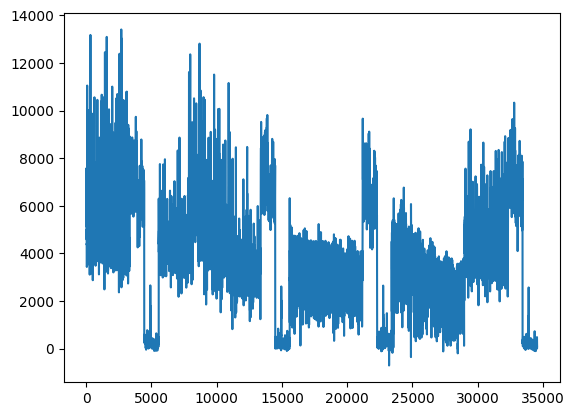

In [86]:
plt.plot(y_pred_test)

In [87]:
train_data.columns

Index(['Store', 'DayOfWeek', 'Sales', 'Customers', 'Open', 'Promo',
       'StateHoliday', 'SchoolHoliday'],
      dtype='object')

In [90]:
lin_reg_pred = pd.read_csv('/content/drive/MyDrive/predictions.csv')

In [102]:
lin_reg_pred[1:10000].shape
lin_reg_pred.head()

,Predictions
0,-1.101371e+10
1,-1.101371e+10
2,-1.101371e+10
3,-1.101371e+10
4,-1.101371e+10


In [103]:
lin_reg_pred.shape
y_pred_df = pd.DataFrame(y_pred_test)
y_pred_df[1:10000].shape
y_pred_df.head()

,0
0,5393.837891
1,5417.947266
2,5202.348145
3,5415.624023
4,5404.588867


In [98]:
y_pred_df = pd.DataFrame(y_pred_test, columns=['Predictions'])

# Ensure the shapes are aligned; this step may need adjustment based on your data's structure
# It's important both DataFrames have the same length
if lin_reg_pred.shape[0] == y_pred_df.shape[0]:
    # Calculate error
    error = lin_reg_pred.iloc[:10000, 0] - y_pred_df.iloc[:10000, 0]  # Adjust column index if necessary

    # Plot the error
    plt.figure(figsize=(10, 6))
    plt.plot(error)
    plt.title('Error between Actual and Predicted Values')
    plt.xlabel('Index')
    plt.ylabel('Error')
    plt.show()
else:
    print("Mismatch in DataFrame lengths")

Mismatch in DataFrame lengths


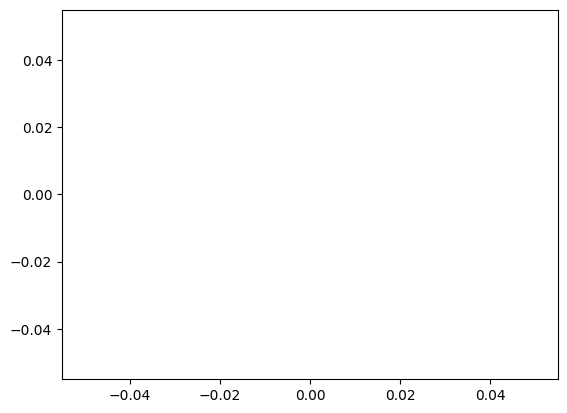

In [97]:
plt.plot(error)